**Table of contents**<a id='toc0_'></a>    
- 1. [Load data ](#toc1_)    
- 2. [Figures](#toc2_)    
  - 2.1. [General activity figure](#toc2_1_)    
  - 2.2. [Detailed figure for supplementary](#toc2_2_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
# Imports
%matplotlib widget
import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
import matplotlib.patheffects as path_effects
import matplotlib.patheffects as fx

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter, LongitudeLocator, LatitudeLocator


# 1. <a id='toc1_'></a>Load data  [&#128285;](#toc0_)

In [2]:
# Load catalogs
# Tremor
trm = pd.read_csv('../data/cascadia/processed/casc_trm_0809_0624.csv', parse_dates=['date'])

# Earthquakes
eq = pd.read_csv('../data/cascadia/processed/casc_eq_0809_0624.csv')

strip = lambda x: str.removesuffix(x, '+00:00')
eq['date'] = list(map(strip, eq.date))
eq['date'] = pd.to_datetime(eq.date, format='mixed')

In [3]:
# Load results and extract results of interest
min_mag = 2.2
dist = 50
v_min = 3.5
dx_bin = 10
cc_thr = 0.07

# Load results
results = pickle.load(open('../results/cascadia/casc_synch.pkl', 'rb'))

n_felt_eqs = results['n_felt_eqs']
corr_lengths = results['corr_lengths']

# Extract
n_felt_eq = n_felt_eqs[f'dx{dx_bin:d}km'][f'm{min_mag:.1f}'][f'{dist:d}km']
corr_length = corr_lengths[f'dx{dx_bin:d}km'][f'v{v_min:.1f}kmd'][f'cc{cc_thr:.2f}']

xmin = results['parameters']['xmin_bin']
xmax = results['parameters']['xmax_bin']
x_bin_edges = np.arange(xmin, xmax+dx_bin, dx_bin)

# 2. <a id='toc2_'></a>Figures [&#128285;](#toc0_)
## 2.1. <a id='toc2_1_'></a>General activity figure [&#128285;](#toc0_)

/Users/gaspard/mambaforge/envs/eqvlfe/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


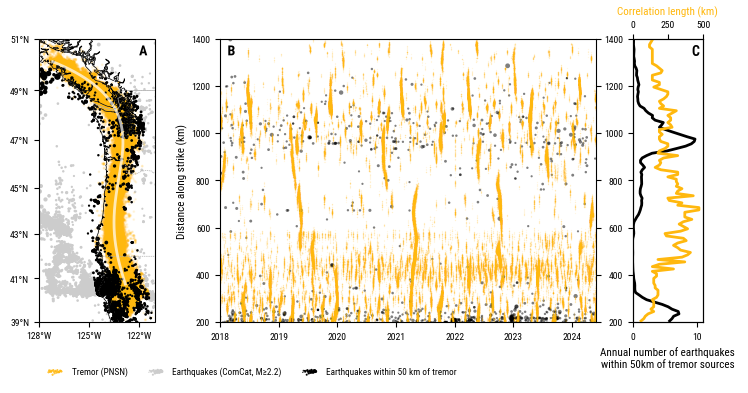

In [4]:
# General activity figure
with plt.style.context('grl'):
    fig = plt.figure(figsize=np.array([19, 10])/2.54)
    gs = fig.add_gridspec(1, 3, width_ratios=[2, 8, 1.5])
    fig.set_facecolor('.95')

    # Map
    crs = ccrs.Mercator()

    aspect_ratio = 12.7/5.3
    top = .9
    left = -.02
    width = .3
    height = width * aspect_ratio
    x0, y0 = left, top - height
    ax = plt.axes([x0, y0, width, height], projection=crs)

    min_lon, max_lon = -128, -121
    min_lat, max_lat = 39, 51
    ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
    ax.coastlines(lw=.5, zorder=12)
    ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=.5, color='.7', zorder=10)
    ax.add_feature(cfeature.STATES, linestyle=':', linewidth=.5, edgecolor='.7', zorder=11)

    ax.set_xticks(np.arange(min_lon, max_lon, 3), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(min_lat, max_lat+2, 2), crs=ccrs.PlateCarree())

    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())

    ax.scatter(trm.lon, trm.lat, s=1, c=[to_rgba('C2', .1) for ii in range(len(trm))], transform=ccrs.PlateCarree(), rasterized=True)
    ax.scatter([], [], s=1, c=[to_rgba('C2', 1)], transform=ccrs.PlateCarree(), rasterized=True, label='Tremor (PNSN)')  # for the legend

    ax.scatter(eq[eq.mag > min_mag].lon, eq[eq.mag > min_mag].lat, s=eq[eq.mag > min_mag].mag**2/2, c=[to_rgba('.8', 1) for ii in range(len(eq[eq.mag > min_mag]))], transform=ccrs.PlateCarree(), edgecolor=[0,0,0,0], zorder=-1, rasterized=True, label='Earthquakes (ComCat, M≥2.2)')
    ax.scatter(eq.lon[(eq.dist2trm < dist) & (eq.mag > min_mag)], eq.lat[(eq.dist2trm < dist) & (eq.mag > min_mag)], s=eq.mag[(eq.dist2trm < dist) & (eq.mag > min_mag)]**2/2, c=[to_rgba('k', 1) for ii in range(len(eq[(eq.dist2trm < dist) & (eq.mag > min_mag)]))], transform=ccrs.PlateCarree(), edgecolor=[0,0,0,0], zorder=1, rasterized=True, label='Earthquakes within 50 km of tremor')

    along_strike = pickle.load(open('../data/cascadia/processed/cascadia_along_strike.pkl', 'rb'))
    along_strike_lon = along_strike['lon'][(along_strike['s'] > 200) & (along_strike['s'] < 1400)]
    along_strike_lat = along_strike['lat'][(along_strike['s'] > 200) & (along_strike['s'] < 1400)]
    
    ax.plot(along_strike_lon, along_strike_lat, ls='-', lw=2, color=to_rgba('w', .7), transform=ccrs.PlateCarree(), zorder=13)

    ax.text(.93, .98, 'A', transform=ax.transAxes, fontsize=10, fontweight='bold', va='top', ha='right', path_effects=[path_effects.withStroke(linewidth=3, foreground='w')])

    # Time-strike
    ax = fig.add_subplot(gs[1])
    ax.set_ylabel('Distance along strike (km)', labelpad=2)
    ax.tick_params(right=True)
    ax.set_xlim(trm.date.min(), trm.date.max())
    ax.set_xlim(np.datetime64('2018-01-01'), np.datetime64('2024-06-01'))
    ax.set_ylim(200, 1400)

    ax.plot(trm.date[(trm.date > np.datetime64('2018-01-01')) & (trm.date < np.datetime64('2024-06-01'))], trm.xf[(trm.date > np.datetime64('2018-01-01')) & (trm.date < np.datetime64('2024-06-01'))], ls='', marker='o', mfc=to_rgba('C2', .1), mec=[0,0,0,0], ms=1, rasterized=True)
    indicator = (eq.dist2trm < dist) & (eq.mag > min_mag)
    ax.scatter(eq.date[indicator], eq.xf[indicator], c=[to_rgba('k', .5) for ii in range(indicator.sum())], s=eq.mag[indicator]**2 / 2, zorder=1, edgecolor=[0,0,0,0], rasterized=True)

    ax.text(.02, .98, 'B', transform=ax.transAxes, fontsize=10, fontweight='bold', va='top', ha='left', path_effects=[path_effects.withStroke(linewidth=3, foreground='w')])

    # Earthquake activity vs correlation length
    ax = fig.add_subplot(gs[2], sharey=ax)
    ax.set_xlabel(f'Annual number of earthquakes\nwithin {dist}km of tremor sources')
    ax.set_xlim(0, 11)

    ax.plot(n_felt_eq, x_bin_edges[:-1] + dx_bin/2, 'k-', lw=2)

    ax_cc = ax.twiny()
    ax_cc.set_xlim(0, 500)
    ax_cc.set_xlabel('Correlation length (km)', color='C2')
    ax_cc.plot(corr_length, x_bin_edges[:-1] + dx_bin/2, 'C2-', lw=2)

    ax.text(.95, .98, 'C', transform=ax.transAxes, fontsize=10, fontweight='bold', va='top', ha='right')

    fig.legend(bbox_to_anchor=(0.05, .02), loc='lower left', scatterpoints=20, markerscale=.5, scatteryoffsets=.5+np.random.randn(20)*.2, fontsize='small', ncol=3)

    plt.subplots_adjust(top=.9, bottom=.18, left=.12, right=.94, wspace=.2)
#    plt.savefig('figures/cascadia_activity.pdf', dpi=400)
#   plt.savefig('../figures/cascadia_activity.png', dpi=400)
    plt.show()

## 2.2. <a id='toc2_2_'></a>Detailed figure for supplementary [&#128285;](#toc0_)

In [5]:
# Define a short interval for clarity
interval = [np.datetime64('2018-01-01'), np.datetime64('2024-06-01')]
trm_in_interval = trm[(trm.date > interval[0]) & (trm.date < interval[1])]
eq_in_interval = eq[(eq.date > interval[0]) & (eq.date < interval[1])]

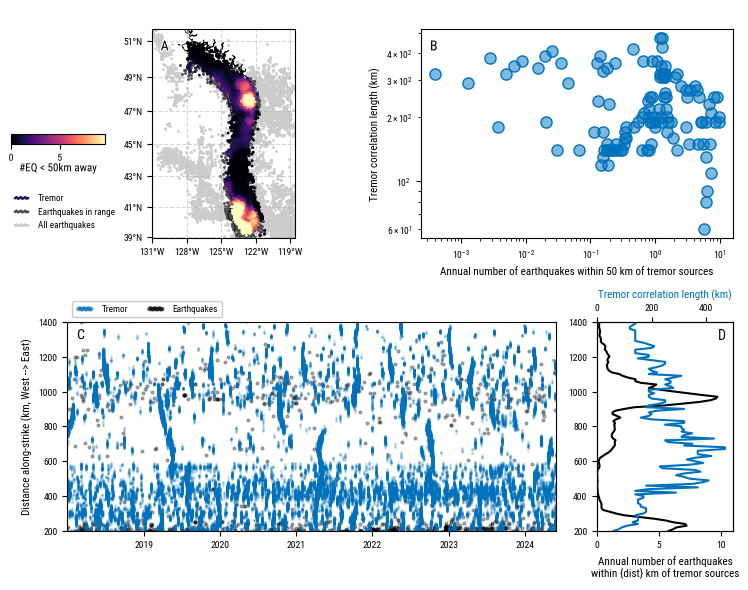

In [6]:
# Plot
with plt.style.context('grl'):
    fig = plt.figure(figsize=np.array([19, 15])/2.54)
    gs = fig.add_gridspec(2, 4, width_ratios=[1, 1, 1, 1], height_ratios=[1, 1])

    plt.subplots_adjust(left=0.09, right=0.98, top=.95, bottom=0.1, wspace=0.3, hspace=0.4)

    # Map
    crs = ccrs.Mercator(central_longitude=trm.lon.mean())
    lon_min = eq.lon.min()
    lon_max = eq.lon.max()
    lat_min = eq.lat.min()
    lat_max = eq.lat.max()

    ax = fig.add_subplot(gs[0, :2], projection=crs)
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    ax.coastlines(lw=.5)

    sc = ax.scatter(trm.lon, trm.lat, c=trm[f'm{min_mag:.1f}in{dist:d}km'], s=1, cmap='magma', transform=ccrs.PlateCarree(), vmin=0, vmax=np.percentile(trm[f'm{min_mag:.1f}in{dist:d}km'], 95), zorder=2, label='Tremor', rasterized=True)
    ax.scatter(eq[(eq.mag > min_mag) & (eq.dist2trm < dist)].lon, eq[(eq.mag > min_mag) & (eq.dist2trm < dist)].lat, c='.3', s=1, transform=ccrs.PlateCarree(), zorder=1, label='Earthquakes in range', rasterized=True)
    ax.scatter(eq.lon, eq.lat, c='.8', s=1, transform=ccrs.PlateCarree(), zorder=0, label='All earthquakes', rasterized=True)

    ax.legend(loc='lower right', bbox_to_anchor=(-.2, 0), fontsize='small', framealpha=0, scatterpoints=10, markerscale=1)

    # Colorbar
    x_min_ax = -0.18; y_min_ax = 0.45
    w_ax = 0.3; h_ax = 0.05
    x_max_ax = x_min_ax + w_ax; y_max_ax = y_min_ax + h_ax

    x_min_fig, y_min_fig = fig.transFigure.inverted().transform(ax.transAxes.transform([x_min_ax, y_min_ax]))
    x_max_fig, y_max_fig = fig.transFigure.inverted().transform(ax.transAxes.transform([x_max_ax, y_max_ax]))
    h_fig = y_max_fig - y_min_fig
    w_fig = x_max_fig - x_min_fig

    cb_ax= fig.add_axes([x_min_fig, y_min_fig, w_fig, h_fig])
    cbar = plt.colorbar(sc, cax=cb_ax, orientation='horizontal', label="#EQ < {:d}km away".format(dist))

    for label in cb_ax.get_xticklabels():
        label.set(path_effects=[fx.withStroke(linewidth=2, foreground='w')])
    cb_ax.xaxis.get_label().set(path_effects=[fx.withStroke(linewidth=3, foreground='w')])
    cb_ax.xaxis.get_label().set_va('center')

    # grid and labels, only bottom and left, not top and right
    ax.set_xticks(np.arange(np.ceil(lon_min), lon_max+1, 3), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(np.ceil(lat_min), lat_max, 2), crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    ax.grid('on', linestyle='--', alpha=0.5)

    ax.text(0.06, 0.95, 'A', fontsize=10, transform=ax.transAxes, ha='left', va='top', path_effects=[fx.withStroke(linewidth=2, foreground='w')])

    # Dot cloud
    ax = fig.add_subplot(gs[0, 2:])
    ax.set_xlabel(f'Annual number of earthquakes within {dist} km of tremor sources')
    ax.set_ylabel('Tremor correlation length (km)')

    ax.plot(n_felt_eq, corr_length, 'o', ms=8, mec='C0', mfc=to_rgba('C0', .5))

    # ax.set_xlim(9, 200)
    ax.set_xscale('log')
    ax.set_yscale('log')

    ax.text(0.03, 0.95, 'B', fontsize=10, transform=ax.transAxes, ha='left', va='top', path_effects=[fx.withStroke(linewidth=2, foreground='w')])

    # Time-strike activity
    ax = fig.add_subplot(gs[1, :3])
    ax.set_ylabel('Distance along-strike (km, West --> East)')

    ax.plot(trm_in_interval.date, trm_in_interval.xf, 'o', ms=1, color=to_rgba('C0', .1), rasterized=True)
    ax.plot(eq_in_interval.date[(eq_in_interval.mag > min_mag) & (eq_in_interval.dist2trm < dist)], eq_in_interval.xf[(eq_in_interval.mag > min_mag) & (eq_in_interval.dist2trm < dist)], 'o', ms=2., color=to_rgba('k', .3), zorder=0, rasterized=True)

    ax.set_xlim(trm_in_interval.date.min(), trm_in_interval.date.max())
    ax.set_ylim(200, 1400)

    ax.scatter([], [], s=5, c=[to_rgba('C0', .5)], label='Tremor')
    ax.scatter([], [], s=5, c=[to_rgba('k', .5)], label='Earthquakes')
    ax.legend(loc='lower left', bbox_to_anchor=(0, 1.), framealpha=1, fontsize='small', scatterpoints=10, markerscale=1, ncols=2)

    ax.text(0.02, 0.97, 'C', fontsize=10, transform=ax.transAxes, ha='left', va='top', path_effects=[fx.withStroke(linewidth=2, foreground='w')])

    # Histogram
    ax = fig.add_subplot(gs[1, 3], sharey=ax)
    ax.set_xlabel('Annual number of earthquakes\nwithin {dist} km of tremor sources')
    ax.set_xlim(0, 11)

    ax.plot(n_felt_eq, x_bin_edges[:-1], c='k')

    ax_cc = ax.twiny()
    ax_cc.set_xlim(0, 500)
    ax_cc.plot(corr_length, x_bin_edges[:-1], 'C0')
    ax_cc.set_xlabel('Tremor correlation length (km)', color='C0')

    ax.text(0.95, 0.97, 'D', fontsize=10, transform=ax.transAxes, ha='right', va='top')
    
    plt.savefig('../figures/cascadia_supp.png', dpi=300)
    plt.savefig('../figures/cascadia_supp.pdf', dpi=300)
    plt.show()